In [1]:
pip install sktime scikit-learn numpy pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer


In [5]:
import pandas as pd
import numpy as np


file_path = "Datasets/VanilaDataset"
trainDataset = pd.read_csv(file_path + "/trainDataset_w_aug.csv", index_col=[0, 1])
testDataset = pd.read_csv(file_path + "/testDataset_w_aug.csv" , index_col=[0, 1])


In [4]:
trainDataset

Open      High       Low     Close    Volume  Pattern
Instance Time                                                           
0        0     0.873210  1.000000  0.809816  0.961145  0.459756        5
         1     0.963190  0.970348  0.831288  0.905930  0.581532        5
         2     0.649284  0.745399  0.525562  0.589979  1.000000        5
         3     0.657464  0.665644  0.547035  0.586912  0.515724        5
         4     0.618609  0.676892  0.596115  0.620654  0.145366        5
...                 ...       ...       ...       ...       ...      ...
6972     15    0.786517  0.887641  0.713483  0.842697  0.353623        1
         16    0.848314  0.848314  0.508427  0.511236  0.300076        1
         17    0.488764  0.693820  0.379213  0.662921  0.425858        1
         18    0.730337  0.780899  0.556180  0.676966  0.381770        1
         19    0.733146  0.797753  0.432584  0.471910  0.209230        1

[322317 rows x 6 columns]

In [5]:
testDataset

Open      High       Low     Close    Volume  Pattern
Instance Time                                                           
0        0     0.811593  0.908213  0.800321  0.863123  0.617661        4
         1     0.906602  1.000000  0.801932  0.951690  0.280122        4
         2     0.816425  0.835748  0.677939  0.729469  0.773254        4
         3     0.776168  0.776168  0.328501  0.362319  0.735597        4
         4     0.357487  0.489532  0.305957  0.397745  0.561676        4
...                 ...       ...       ...       ...       ...      ...
1744     56    0.339680  0.410202  0.330277  0.406676  0.427858        6
         57    0.427833  0.558298  0.414904  0.420780  1.000000        6
         58    0.421956  0.484250  0.374941  0.412553  0.410233        6
         59    0.418430  0.453103  0.385520  0.412553  0.213140        6
         60    0.401975  0.409027  0.346732  0.383169  0.168578        6

[78940 rows x 6 columns]

In [6]:
# get the data where th e0 level index Instance is 1 in the trainDataset
trainDataset.loc[7]

,Open,High,Low,Close,Volume,Pattern
Time,,,,,,
0,0.681682,0.735135,0.583784,0.694294,0.058945,1
1,0.708709,0.943543,0.708709,0.906306,0.063957,1
2,0.851051,0.860661,0.645646,0.750751,0.042797,1
3,0.890090,0.960360,0.751351,0.960360,0.041285,1
4,0.793393,0.873874,0.688288,0.743543,0.060536,1
...,...,...,...,...,...,...
101,0.506907,0.511111,0.446246,0.465465,0.017421,1
102,0.461261,0.585586,0.446246,0.552552,0.012410,1
103,0.550150,0.591591,0.478679,0.502102,0.019092,1


In [6]:
import numpy as np

def prepare_rocket_data(dataset, features, target='Pattern'):
    """
    Prepares data for ROCKET classifier.

    Args:
    - dataset (DataFrame): MultiIndex DataFrame with levels ['Instance', 'Time'].
    - features (list): List of feature columns (e.g., ['Open', 'High', ...]).
    - target (str): Target column name (default: 'Pattern').

    Returns:
    - X (np.array): Features reshaped to (num_samples, series_length, num_features).
    - y (np.array): Target labels (one per instance).
    """
    # Determine the maximum series length
    series_length = dataset.index.get_level_values('Time').max() + 1
    num_features = len(features)
    num_samples = len(dataset.index.get_level_values('Instance').unique())

    # Prepare feature matrix (X)
    X = np.full((num_samples, series_length, num_features), fill_value=np.nan)  # Initialize with NaNs
    for instance, group in dataset.groupby(level=0):  # Group by 'Instance'
        time_steps = group.index.get_level_values('Time').values
        X[instance, time_steps, :] = group[features].values  # Fill in feature values

    # Prepare target labels (y)
    y = dataset.groupby(level=0)[target].first().values  # Take the first target for each instance

    return X, y

# Define features
features = ['Open', 'High', 'Low', 'Close',  'Volume']
# features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Prepare training and testing data
X_train, y_train = prepare_rocket_data(trainDataset, features)
X_test, y_test = prepare_rocket_data(testDataset, features)

print(f"X_train shape: {X_train.shape}")  # Expect (num_samples, series_length, num_features)
print(f"y_train shape: {y_train.shape}")  # Expect (num_samples,)


X_train shape: (7080, 486, 5)
y_train shape: (7080,)


In [8]:
y_test

array([4, 1, 6, ..., 6, 7, 6], dtype=int64)

In [9]:
X_test

array([[[0.81159324, 0.9082126 , 0.80032115, 0.86312299, 0.61766091],
        [0.90660195, 1.        , 0.8019318 , 0.95169032, 0.28012166],
        [0.81642519, 0.83574808, 0.67793876, 0.72946851, 0.77325353],
        ...,
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan]],

       [[0.10821719, 0.22864033, 0.        , 0.15866548, 0.204033  ],
        [0.14890072, 0.2359639 , 0.07160231, 0.22131824, 0.2591379 ],
        [0.27176505, 0.41171623, 0.09926764, 0.38893476, 0.33662929],
        ...,
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan]],

       [[0.43988272, 0.5131965 , 0.40175952, 0.48973611, 0.84557572],
        [0.46334311, 0.54252199, 0.45161291, 0.52639301, 0.5

In [10]:
print(X_train[0])  # Features for the first sample


[[0.8732105  1.         0.80981594 0.9611451  0.45975619]
 [0.96319013 0.97034756 0.83128823 0.90593029 0.58153214]
 [0.64928432 0.74539867 0.52556217 0.58997944 1.        ]
 ...
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]]


In [11]:

print(y_train[0])  # Target for the first sample


5


In [12]:
X_train.shape

(6973, 501, 5)

In [7]:
import numpy as np
import pandas as pd

def adjust_series_length(group, target_length):
    """
    Adjusts a time series to a target length.
    - Truncates if longer than target_length.
    - Pads with zeros if shorter than target_length.

    Args:
    - group (DataFrame): Subgroup of data (single instance).
    - target_length (int): Desired series length.

    Returns:
    - np.array: Adjusted series as a NumPy array.
    """
    series = group.values
    current_length = len(series)

    if current_length > target_length:
        return series[:target_length]
    else:
        # Padding with zeros if shorter
        padding = np.zeros((target_length - current_length, series.shape[1]))
        return np.vstack([series, padding])


In [8]:
# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Pattern'
series_length = 100  # Target series length for ROCKET


def prepare_rocket_data(dataset, features, target, series_length):
    # Group by 'Instance' and adjust each series length
    adjusted = dataset.groupby(level=0).apply(
        lambda group: adjust_series_length(group[features], series_length)
    )

    # Stack adjusted arrays
    X = np.stack(adjusted.values)  # Shape: (num_samples, series_length, num_features)

    # Extract targets (one per instance)
    y = dataset.groupby(level=0)[target].first().values  # Shape: (num_samples,)
    
    X = np.transpose(X, (0, 2, 1)) # shape: (num_samples, num_features, series_length)

    return X, y

# Prepare training and testing data
X_train, y_train = prepare_rocket_data(trainDataset, features, target, series_length)
X_test, y_test = prepare_rocket_data(testDataset, features, target, series_length)

print(f"X_train shape: {X_train.shape}")  # Expect (2237, 275, 6)
print(f"y_train shape: {y_train.shape}")  # Expect (2237,)


X_train shape: (7080, 5, 100)
y_train shape: (7080,)


In [15]:
# X_train = np.transpose(X_train, (0, 2, 1))
# X_test = np.transpose(X_test, (0, 2, 1))

In [16]:
print(y_train)

[5 3 6 ... 2 3 1]


In [17]:
type(y_train)

numpy.ndarray

In [18]:
type(X_train)

numpy.ndarray

In [19]:
y_test

array([4, 1, 6, ..., 6, 7, 6], dtype=int64)

In [20]:
y_test.shape

(1745,)

In [21]:
print(X_train[0])  # Features for the first sample


[[0.8732105  0.96319013 0.64928432 0.65746407 0.61860916 0.77709614
  0.74335363 0.61860916 0.74437635 0.78629861 0.56952947 0.46421265
  0.5327196  0.42842549 0.41411024 0.35276072 0.55214725 0.37321069
  0.23006129 0.19427413 0.17382416 0.30981613 0.37116565 0.41002056
  0.46012258 0.44989779 0.42842549 0.38241316 0.37423301 0.2474439
  0.40388545 0.57770961 0.57770961 0.57259722 0.560327   0.6319017
  0.66359918 0.52658488 0.41002056 0.46012258 0.25051126 0.02249501
  0.03987723 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         

In [22]:
print(y_train[0])  # Target for the first sample


5


In [23]:
X_train

array([[[0.8732105 , 0.96319013, 0.64928432, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.97034756, 0.74539867, ..., 0.        ,
         0.        , 0.        ],
        [0.80981594, 0.83128823, 0.52556217, ..., 0.        ,
         0.        , 0.        ],
        [0.9611451 , 0.90593029, 0.58997944, ..., 0.        ,
         0.        , 0.        ],
        [0.45975619, 0.58153214, 1.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.70250544, 0.67014582, 0.56680577, ..., 0.        ,
         0.        , 0.        ],
        [0.75365343, 0.72129461, 0.65657617, ..., 0.        ,
         0.        , 0.        ],
        [0.68684766, 0.63361154, 0.53027149, ..., 0.        ,
         0.        , 0.        ],
        [0.69206639, 0.65553211, 0.53966568, ..., 0.        ,
         0.        , 0.        ],
        [0.13474026, 0.3023838 , 0.56173958, ..., 0.        ,
         0.        , 0.        ]],

       [[0.00945179, 0.02835536, 0.0

In [24]:
X_test

array([[[0.81159324, 0.90660195, 0.81642519, ..., 0.        ,
         0.        , 0.        ],
        [0.9082126 , 1.        , 0.83574808, ..., 0.        ,
         0.        , 0.        ],
        [0.80032115, 0.8019318 , 0.67793876, ..., 0.        ,
         0.        , 0.        ],
        [0.86312299, 0.95169032, 0.72946851, ..., 0.        ,
         0.        , 0.        ],
        [0.61766091, 0.28012166, 0.77325353, ..., 0.        ,
         0.        , 0.        ]],

       [[0.10821719, 0.14890072, 0.27176505, ..., 0.        ,
         0.        , 0.        ],
        [0.22864033, 0.2359639 , 0.41171623, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.07160231, 0.09926764, ..., 0.        ,
         0.        , 0.        ],
        [0.15866548, 0.22131824, 0.38893476, ..., 0.        ,
         0.        , 0.        ],
        [0.204033  , 0.2591379 , 0.33662929, ..., 0.        ,
         0.        , 0.        ]],

       [[0.43988272, 0.46334311, 0.5

# Rocket With Logistic Regression


In [16]:
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sktime.datasets import load_unit_test  # Example dataset
from sklearn.metrics import classification_report, accuracy_score

In [26]:
# rocket = Rocket(num_kernels=10000)
# clf = make_pipeline(rocket, LogisticRegression(max_iter=5000, multi_class='multinomial', solver='lbfgs'))


# print("Fitting the pipeline to the training dataset...")
# clf.fit(X_train, y_train)

In [27]:
# y_train_probs = clf.predict_proba(X_train)  # Training set probabilities
# y_test_probs = clf.predict_proba(X_test)

In [28]:
# y_test_probs

In [29]:
# y_train_probs

In [30]:
# from sklearn.metrics import accuracy_score

# # Training accuracy
# y_train_pred = y_train_probs.argmax(axis=1)  # Predicted classes for training data
# train_accuracy = accuracy_score(y_train, y_train_pred)
# print(f"Training Accuracy: {train_accuracy:.2f}")

# # Testing accuracy
# y_test_pred = y_test_probs.argmax(axis=1)  # Predicted classes for test data
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f"Test Accuracy: {test_accuracy:.2f}")


# Rocket With XGBoost


In [17]:
from xgboost import XGBClassifier
from sktime.transformations.panel.padder import PaddingTransformer

padder = PaddingTransformer(pad_length=100, fill_value=0)
rocket = Rocket(num_kernels=10000)


clf_xgb = make_pipeline(
    padder,
    rocket,
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100)
)
clf_xgb.fit(X_train, y_train)


c:\Users\gwiku\miniconda3\envs\FYPenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:06:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('paddingtransformer', PaddingTransformer(pad_length=100)),
                ('rocket', Rocket()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=No...None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [18]:
y_test_probs

array([[3.70251574e-03, 1.21986724e-01, 7.01793879e-02, ...,
        7.40356624e-01, 1.06901559e-03, 9.47787834e-04],
       [1.73829775e-03, 9.90588784e-01, 1.40084687e-03, ...,
        1.04372238e-03, 1.97847839e-04, 1.84185265e-04],
       [9.98949587e-01, 2.87594419e-04, 1.34122412e-04, ...,
        1.06567051e-04, 3.10882489e-04, 6.41678707e-05],
       ...,
       [7.19877484e-04, 9.41440085e-05, 2.71114041e-05, ...,
        6.68283537e-05, 5.94571902e-05, 4.60660958e-05],
       [4.17514518e-03, 4.74964688e-03, 2.24038522e-04, ...,
        5.83354122e-05, 1.23194579e-04, 6.29878559e-05],
       [6.76416312e-05, 3.30612020e-05, 4.47157618e-05, ...,
        1.50980268e-05, 9.99746263e-01, 5.39746579e-05]], dtype=float32)

In [19]:
y_train_probs = clf_xgb.predict_proba(X_train) 
y_test_probs = clf_xgb.predict_proba(X_test)

In [20]:
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = y_train_probs.argmax(axis=1)  
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Testing accuracy
y_test_pred = y_test_probs.argmax(axis=1)  
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.83


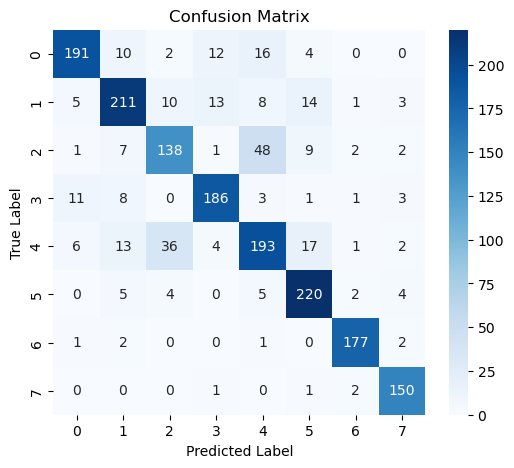

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [22]:
# save the pipelined model
import joblib
joblib.dump(clf_xgb, "rocket_model_w_aug.pkl")

['rocket_model_w_aug.pkl']

In [23]:
import os
import joblib

model_save_dir = ''
pipeline = joblib.load(os.path.join(model_save_dir, "rocket_model.pkl"))
# predict on the subset of the test data


In [24]:
y_pred_test = clf_xgb.predict_proba(X_test)
y_pred_test

array([[6.1635242e-04, 1.5551228e-03, 1.8179628e-01, ..., 1.2071491e-03,
        1.0769570e-04, 3.8312588e-05],
       [1.9440930e-02, 1.1230562e-02, 3.1809679e-01, ..., 4.5141461e-03,
        1.9314711e-03, 2.1878618e-04],
       [7.9182696e-01, 1.9368623e-01, 1.8723783e-03, ..., 2.4113421e-04,
        3.1334599e-03, 9.7973490e-05],
       ...,
       [5.4940156e-04, 6.6390574e-05, 8.5842848e-06, ..., 3.0116395e-05,
        3.0248557e-06, 1.8182216e-06],
       [8.8120186e-01, 2.6495783e-03, 1.3509293e-03, ..., 1.3033605e-04,
        5.0225458e-04, 6.6034467e-05],
       [1.2741681e-06, 4.3036284e-06, 4.8639977e-06, ..., 9.1907887e-06,
        9.9995077e-01, 1.0422358e-05]], dtype=float32)

In [25]:
import numpy as np

def filter_predictions_with_threshold(y_pred_test, threshold):
    # Get the class with the maximum probability for each sample
    max_probs = np.max(y_pred_test, axis=1)  # Maximum probability for each sample
    max_classes = np.argmax(y_pred_test, axis=1)  # Corresponding class for max probability
    
    # Apply threshold condition
    results = np.where(max_probs >= threshold, max_classes, -1)
    
    return results


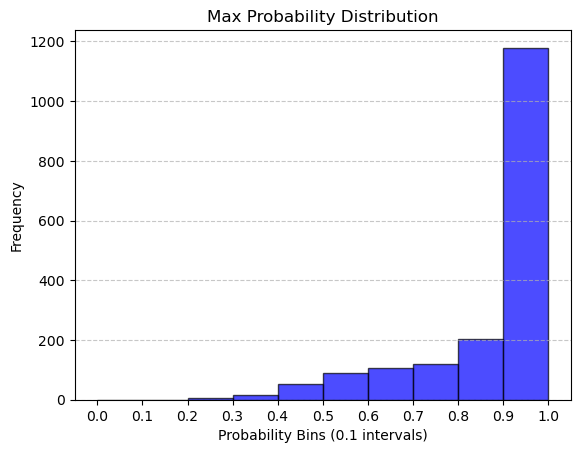

array([4, 4, 0, ..., 3, 0, 6], dtype=int64)

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def filter_predictions_with_threshold(y_pred_test, threshold):
    # Get the max probability for each sample
    max_probs = np.max(y_pred_test, axis=1)
    max_classes = np.argmax(y_pred_test, axis=1)  # Class with max probability

    # Apply threshold condition
    results = np.where(max_probs >= threshold, max_classes, -1)
    
    # Plot a bar graph of max probabilities
    plot_max_probability_bar_graph(max_probs)
    
    return results

def plot_max_probability_bar_graph(max_probs):
    # Create bins for the probabilities (0.0 to 1.0 with a step of 0.1)
    bins = np.arange(0, 1.1, 0.1)
    
    # Plot the histogram
    plt.hist(max_probs, bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title('Max Probability Distribution')
    plt.xlabel('Probability Bins (0.1 intervals)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(bins)  # Ensure bins align with ticks
    plt.show()

filter_predictions_with_threshold(y_pred_test, 0.5)

# Mini Rocket with XGBoost


In [27]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from xgboost import XGBClassifier

mini_rocket = MiniRocketMultivariate(num_kernels=10000 , n_jobs=-1)
clf_mini_rocket_xgb = make_pipeline(
    mini_rocket,
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100)
)
clf_mini_rocket_xgb.fit(X_train, y_train)

c:\Users\gwiku\miniconda3\envs\FYPenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:26:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('minirocketmultivariate', MiniRocketMultivariate(n_jobs=-1)),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [28]:
y_train_probs = clf_mini_rocket_xgb.predict_proba(X_train) 
y_test_probs = clf_mini_rocket_xgb.predict_proba(X_test)

In [29]:
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = y_train_probs.argmax(axis=1)  
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Testing accuracy
y_test_pred = y_test_probs.argmax(axis=1)  
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.78


In [30]:
# save the pipelined model
import joblib
joblib.dump(clf_mini_rocket_xgb, "mini_rocket_model_w_aug.pkl")


['mini_rocket_model_w_aug.pkl']

# MultiRocket XGBoost


In [31]:
from sktime.transformations.panel.rocket import MultiRocketMultivariate
from xgboost import XGBClassifier

multi_rocket = MultiRocketMultivariate(num_kernels=10000 , n_jobs=-1)
clf_multi_rocket_xgb = make_pipeline(
    multi_rocket,
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100)
)
clf_multi_rocket_xgb.fit(X_train, y_train)

c:\Users\gwiku\miniconda3\envs\FYPenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:32:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
y_train_probs = clf_multi_rocket_xgb.predict_proba(X_train) 
y_test_probs = clf_multi_rocket_xgb.predict_proba(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

# Training accuracy
y_train_pred = y_train_probs.argmax(axis=1)  
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Testing accuracy
y_test_pred = y_test_probs.argmax(axis=1)  
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.80


In [ ]:
# save the pipelined model
import joblib
joblib.dump(clf_multi_rocket_xgb, "multi_rocket_model_w_aug.pkl")


['multi_rocket_model.pkl']

In [ ]:
import os


model_save_dir = ''
pipeline = joblib.load(os.path.join(model_save_dir, "rocket_model_w_aug.pkl"))
# predict on the subset of the test data
y_pred = pipeline.predict(X_test)

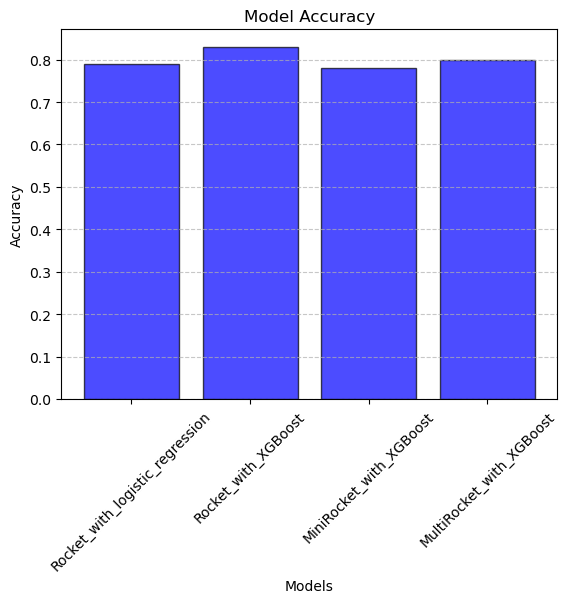

In [ ]:
#  draw a bar graph of every models accuracy
import matplotlib.pyplot as plt

models = ['Rocket_with_logistic_regression', 'Rocket_with_XGBoost', 'MiniRocket_with_XGBoost', 'MultiRocket_with_XGBoost']

accuracies = [0.79,  0.83,0.78, 0.80]

plt.bar(models, accuracies, color='blue', alpha=0.7, edgecolor='black')
plt.title('Model Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()